In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt

palette = 'muted'
sns.set_palette(palette)
sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# Step 1: 导入数据

In [3]:
data_case = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_case4_norm_10.csv", index_col=0)
data_ctrl = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_ctrl4_norm_10.csv", index_col=0)

data_case = data_case.transpose()
data_ctrl = data_ctrl.transpose()

print(data_case.shape)
print(data_ctrl.shape)

(113, 10)
(113, 10)


In [8]:
data_case.head()

,LGALS7B|653499,SDPR|8436,EBF1|1879,RCC1|1104,MRC1|4360,MRGPRF|116535,SLCO1A2|6579,PRRT4|401399,GRIN2D|2906,ARNT2|9915
0,0.20,0.36,0.41,0.49,0.32,0.34,0.21,0.22,0.36,0.55
1,0.08,0.39,0.47,0.54,0.33,0.40,0.08,0.21,0.38,0.53
2,0.00,0.28,0.35,0.59,0.38,0.35,0.11,0.12,0.37,0.58
3,0.05,0.42,0.41,0.53,0.49,0.37,0.00,0.22,0.24,0.59
4,0.15,0.49,0.47,0.55,0.46,0.43,0.19,0.24,0.31,0.53


In [7]:
data_ctrl.head()

,LGALS7B|653499,SDPR|8436,EBF1|1879,RCC1|1104,MRC1|4360,MRGPRF|116535,SLCO1A2|6579,PRRT4|401399,GRIN2D|2906,ARNT2|9915
0,0.05,0.67,0.65,0.40,0.59,0.48,0.10,0.50,0.23,0.35
1,0.25,0.59,0.55,0.47,0.44,0.45,0.31,0.48,0.24,0.47
2,0.10,0.57,0.55,0.45,0.48,0.50,0.08,0.36,0.23,0.43
3,0.05,0.62,0.59,0.52,0.59,0.45,0.47,0.41,0.31,0.60
4,0.15,0.64,0.59,0.48,0.55,0.49,0.31,0.42,0.25,0.48


# Step 2: 建立模型

In [6]:
data_case.index = data_ctrl.index = range(data_case.shape[0])

In [9]:
K = data_case.shape[1]
I = data_case.shape[0]
print("This data have %d samples and each has %d features" % (I, K))

data_x = np.array(data_case - data_ctrl)
data_y = np.ones(I)

print(data_x)
print(data_y)

This data have 113 samples and each has 10 features
[[ 0.15 -0.32 -0.24 ..., -0.28  0.13  0.21]
 [-0.17 -0.2  -0.08 ..., -0.27  0.14  0.06]
 [-0.1  -0.3  -0.2  ..., -0.24  0.14  0.14]
 ..., 
 [ 0.1  -0.04 -0.01 ...,  0.14  0.09  0.05]
 [-0.2  -0.14 -0.07 ..., -0.1   0.06  0.08]
 [-0.18 -0.09 -0.02 ...,  0.02  0.07  0.02]]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]


In [10]:
with pm.Model() as model:
    # hyper-priors
    w_c = pm.HalfCauchy('w_c', beta=5)
    w_d = pm.HalfCauchy('w_d', beta=5)
    
    beta_sigma = pm.Normal('b_sigma', mu=0, sd=5)
    beta_deta0 = 1
    
    # prioris
    w = pm.Beta('w', alpha=w_c, beta=w_d, shape=K)
    r = pm.Bernoulli('r', w, shape=K)
    
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = r*beta_sigma + (1-r)*beta_deta0
    
    # predictor
    mu = alpha + pm.math.dot(data_x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    
    # define likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_y)
    
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_1 = pm.sample(100, step, start)
    #trace_s = pm.sample(2000)
    

logp = 1,705.8, ||grad|| = 3.8419e+05: 100%|██████████| 69/69 [00:00<00:00, 1603.90it/s]  
Assigned BinaryGibbsMetropolis to r
 97%|█████████▋| 581/600 [00:03<00:00, 162.05it/s]/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 100 samples.
  % (self._chain_id, n))
/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 5 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 600/600 [00:03<00:00, 163.02it/s]


In [11]:
with model:
    trace_s = pm.sample(50000, trace=trace_1)

Assigned NUTS to w_c_log__
Assigned NUTS to w_d_log__
Assigned NUTS to b_sigma
Assigned NUTS to w_logodds__
Assigned BinaryGibbsMetropolis to r
Assigned NUTS to alpha
100%|█████████▉| 50494/50500 [04:41<00:00, 179.36it/s]/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 3057 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 50500/50500 [04:41<00:00, 179.36it/s]


In [12]:
np.save(arr=trace_s, file="TCGA_trace_10")

[]

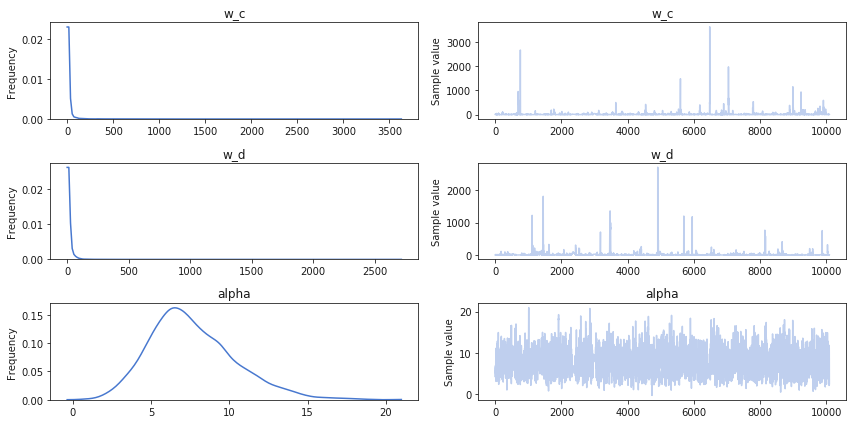

In [13]:
trace_10 = trace_s
chain_10 = trace_10[40000:]
varnames = ['w_c', 'w_d','alpha']
pm.traceplot(chain_10, varnames)
plt.plot()

In [14]:
pm.df_summary(chain_10, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
w_c,17.49,78.93,2.10,0.03,52.34
w_d,16.83,76.42,3.02,0.09,51.43
alpha,7.66,2.75,0.07,2.69,13.27


(10100, 10)
[ 0.51  0.53  0.52  0.5   0.51  0.52  0.52  0.52  0.5   0.49]


[]

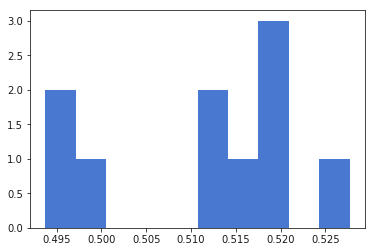

In [16]:
r_features = chain_10['r']
print(r_features.shape)

var_importance = r_features.mean(axis=0)
print(var_importance)
plt.hist(var_importance)
plt.plot()

In [17]:
df_result = pd.DataFrame()
df_result['features'] = data_case.columns.values
df_result['importance'] = var_importance

df_result = df_result.sort_values('importance', ascending=False)
df_result

,features,importance
1,SDPR|8436,0.53
7,PRRT4|401399,0.52
6,SLCO1A2|6579,0.52
2,EBF1|1879,0.52
5,MRGPRF|116535,0.52
0,LGALS7B|653499,0.51
4,MRC1|4360,0.51
3,RCC1|1104,0.50
8,GRIN2D|2906,0.50
9,ARNT2|9915,0.49


In [18]:
df_result.to_csv(path_or_buf="/home/lsen/Data/CODE/feature_selection/data/output/6_bayesian_10.csv",index=False)

## Top 50

In [19]:
data_case = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_case4_norm_50.csv", index_col=0)
data_ctrl = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_ctrl4_norm_50.csv", index_col=0)

data_case = data_case.transpose()
data_ctrl = data_ctrl.transpose()

data_case.index = data_ctrl.index = range(data_case.shape[0])

print(data_case.shape)
print(data_ctrl.shape)

K = data_case.shape[1]
I = data_case.shape[0]
print("This data have %d samples and each has %d features" % (I, K))


data_x = np.array(data_case - data_ctrl)
data_y = np.ones(I)

print(data_x)
print(data_y)

(113, 50)
(113, 50)
This data have 113 samples and each has 50 features
[[ 0.15 -0.32 -0.24 ..., -0.17 -0.24  0.16]
 [-0.17 -0.2  -0.08 ..., -0.03 -0.02  0.18]
 [-0.1  -0.3  -0.2  ..., -0.13 -0.33 -0.15]
 ..., 
 [ 0.1  -0.04 -0.01 ..., -0.11  0.02  0.1 ]
 [-0.2  -0.14 -0.07 ..., -0.17 -0.07  0.06]
 [-0.18 -0.09 -0.02 ..., -0.1  -0.08 -0.05]]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]


In [20]:
with pm.Model() as model:
    # hyper-priors
    w_c = pm.HalfCauchy('w_c', beta=5)
    w_d = pm.HalfCauchy('w_d', beta=5)
    
    beta_sigma = pm.Normal('b_sigma', mu=0, sd=5)
    beta_deta0 = 1
    
    # prioris
    w = pm.Beta('w', alpha=w_c, beta=w_d, shape=K)
    r = pm.Bernoulli('r', w, shape=K)
    
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = r*beta_sigma + (1-r)*beta_deta0
    
    # predictor
    mu = alpha + pm.math.dot(data_x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    
    # define likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_y)
    
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_50 = pm.sample(50000, step, start)

logp = 362.09, ||grad|| = 6.1924e+06: 100%|██████████| 70/70 [00:00<00:00, 2070.69it/s]       
Assigned BinaryGibbsMetropolis to r
100%|█████████▉| 50499/50500 [10:35<00:00, 79.43it/s]/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.606351167013, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 10147 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 50500/50500 [10:35<00:00, 79.43it/s]


In [21]:
np.save(arr=trace_50, file="TCGA_trace_50")

[]

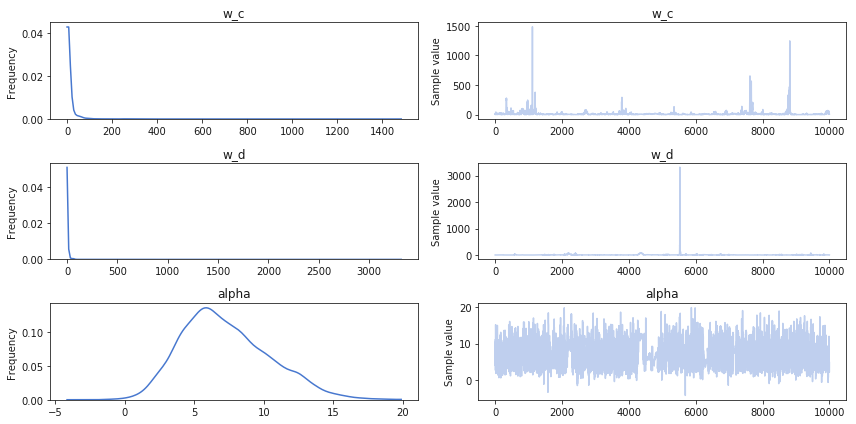

In [22]:
trace_50 = trace_50
chain_50 = trace_50[40000:]
varnames = ['w_c', 'w_d','alpha']
pm.traceplot(chain_50, varnames)
plt.plot()

In [24]:
r_features = chain_50['r']
var_importance = r_features.mean(axis=0)
df_result = pd.DataFrame()
df_result['features'] = data_case.columns.values
df_result['importance'] = var_importance
df_result = df_result.sort_values('importance', ascending=False)

df_result.to_csv(path_or_buf="/home/lsen/Data/CODE/feature_selection/data/output/6_bayesian_50.csv",index=False)

df_result

,features,importance
32,HOXA7|3204,0.61
0,LGALS7B|653499,0.61
1,SDPR|8436,0.61
47,LOC121838|121838,0.61
15,CPA1|1357,0.61
36,CHL1|10752,0.61
48,PLAC9|219348,0.61
5,MRGPRF|116535,0.61
33,HOXA6|3203,0.60
39,RGS6|9628,0.60


# Top100

In [25]:
data_case = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_case4_norm_100.csv", index_col=0)
data_ctrl = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_ctrl4_norm_100.csv", index_col=0)

data_case = data_case.transpose()
data_ctrl = data_ctrl.transpose()

data_case.index = data_ctrl.index = range(data_case.shape[0])
print(data_case.shape)
print(data_ctrl.shape)

K = data_case.shape[1]
I = data_case.shape[0]
print("This data have %d samples and each has %d features" % (I, K))

data_x = np.array(data_case - data_ctrl)
data_y = np.ones(I)

print(data_x)
print(data_y)

(113, 100)
(113, 100)
This data have 113 samples and each has 100 features
[[ 0.15 -0.32 -0.24 ..., -0.25  0.12 -0.06]
 [-0.17 -0.2  -0.08 ..., -0.16  0.11 -0.24]
 [-0.1  -0.3  -0.2  ..., -0.4   0.06 -0.18]
 ..., 
 [ 0.1  -0.04 -0.01 ..., -0.02  0.09 -0.23]
 [-0.2  -0.14 -0.07 ..., -0.08  0.1  -0.16]
 [-0.18 -0.09 -0.02 ..., -0.18  0.05 -0.26]]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]


In [26]:
with pm.Model() as model:
    # hyper-priors
    w_c = pm.HalfCauchy('w_c', beta=5)
    w_d = pm.HalfCauchy('w_d', beta=5)
    
    beta_sigma = pm.Normal('b_sigma', mu=0, sd=5)
    beta_deta0 = 1
    
    # prioris
    w = pm.Beta('w', alpha=w_c, beta=w_d, shape=K)
    r = pm.Bernoulli('r', w, shape=K)
    
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = r*beta_sigma + (1-r)*beta_deta0
    
    # predictor
    mu = alpha + pm.math.dot(data_x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    
    # define likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_y)
    
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_100 = pm.sample(50000, step, start)
    
np.save(arr=trace_100, file="TCGA_trace_100")

logp = -inf, ||grad|| = 10.791: 100%|██████████| 74/74 [00:00<00:00, 215.28it/s]            
Assigned BinaryGibbsMetropolis to r
100%|█████████▉| 50495/50500 [18:28<00:00, 45.57it/s]/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.391420071398, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 21527 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 50500/50500 [18:28<00:00, 45.57it/s]


[]

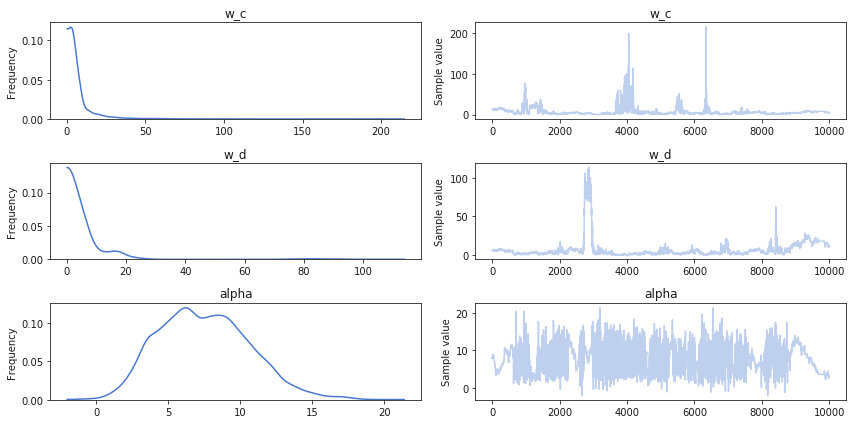

In [27]:
trace = trace_100
chain = trace[40000:]
varnames = ['w_c', 'w_d','alpha']
pm.traceplot(chain, varnames)
plt.plot()

In [29]:
r_features = chain['r']
var_importance = r_features.mean(axis=0)
df_result = pd.DataFrame()
df_result['features'] = data_case.columns.values
df_result['importance'] = var_importance
df_result = df_result.sort_values('importance', ascending=False)

df_result.to_csv(path_or_buf="/home/lsen/Data/CODE/feature_selection/data/output/6_bayesian_100.csv",index=False)

df_result

,features,importance
56,GPM6A|2823,0.56
0,LGALS7B|653499,0.55
28,C2orf71|388939,0.55
32,HOXA7|3204,0.55
5,MRGPRF|116535,0.54
17,ADRB1|153,0.54
85,CNN1|1264,0.54
64,KIAA1045|23349,0.54
71,ANGPTL4|51129,0.54
43,KCNQ4|9132,0.54


# Top1000

In [30]:
data_case = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_case4_norm_1000.csv", index_col=0)
data_ctrl = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_ctrl4_norm_1000.csv", index_col=0)

data_case = data_case.transpose()
data_ctrl = data_ctrl.transpose()

data_case.index = data_ctrl.index =  range(data_case.shape[0])

print(data_case.shape)
print(data_ctrl.shape)

K = data_case.shape[1]
I = data_case.shape[0]
print("This data have %d samples and each has %d features" % (I, K))

data_x = np.array(data_case - data_ctrl)
data_y = np.ones(I)

print(data_x)
print(data_y)

(113, 1000)
(113, 1000)
This data have 113 samples and each has 1000 features
[[ 0.15 -0.32 -0.24 ..., -0.05  0.29  0.  ]
 [-0.17 -0.2  -0.08 ...,  0.14  0.06  0.11]
 [-0.1  -0.3  -0.2  ...,  0.03  0.18 -0.08]
 ..., 
 [ 0.1  -0.04 -0.01 ...,  0.22  0.09  0.13]
 [-0.2  -0.14 -0.07 ...,  0.06  0.05 -0.02]
 [-0.18 -0.09 -0.02 ...,  0.01 -0.01 -0.39]]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]


In [31]:
with pm.Model() as model:
    # hyper-priors
    w_c = pm.HalfCauchy('w_c', beta=5)
    w_d = pm.HalfCauchy('w_d', beta=5)
    
    beta_sigma = pm.Normal('b_sigma', mu=0, sd=5)
    beta_deta0 = 1
    
    # prioris
    w = pm.Beta('w', alpha=w_c, beta=w_d, shape=K)
    r = pm.Bernoulli('r', w, shape=K)
    
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = r*beta_sigma + (1-r)*beta_deta0
    
    # predictor
    mu = alpha + pm.math.dot(data_x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    
    # define likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_y)
    
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_1000 = pm.sample(100000, step, start)
    
np.save(arr=trace_1000, file="TCGA_trace_1000")

logp = nan, ||grad|| = 0: 100%|██████████| 130/130 [00:00<00:00, 978.30it/s]                 
Assigned BinaryGibbsMetropolis to r
100%|██████████| 100500/100500 [13:47:17<00:00,  2.02it/s] /home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.893063644846, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 2352 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self.

,features,importance
148,CA4|762,0.41
786,GPD1|2819,0.41
263,MYOC|4653,0.41
323,FIGF|2277,0.41
660,PI16|221476,0.41


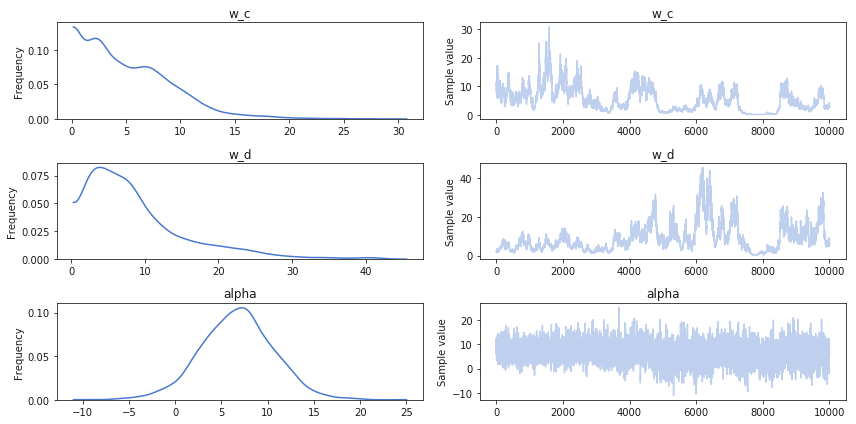

In [33]:
trace = trace_1000
chain = trace[90000:]
varnames = ['w_c', 'w_d','alpha']
pm.traceplot(chain, varnames)
plt.plot()

r_features = chain['r']
var_importance = r_features.mean(axis=0)
df_result = pd.DataFrame()
df_result['features'] = data_case.columns.values
df_result['importance'] = var_importance
df_result = df_result.sort_values('importance', ascending=False)
df_result.to_csv(path_or_buf="/home/lsen/Data/CODE/feature_selection/data/output/6_bayesian_1000.csv",index=False)

df_result.head()

# Top 1500

In [ ]:
data_case = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_case4_1500.csv", index_col=0)
data_ctrl = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_ctrl4_1500.csv", index_col=0)

data_case = data_case.transpose()
data_ctrl = data_ctrl.transpose()

print(data_case.shape)
print(data_ctrl.shape)

K = data_case.shape[1]
I = data_case.shape[0]
print("This data have %d samples and each has %d features" % (I, K))

data_x = np.array(data_case - data_ctrl)
data_y = np.ones(I)

print(data_x)
print(data_y)

In [ ]:
with pm.Model() as model:
    # hyper-priors
    w_c = pm.HalfCauchy('w_c', beta=5)
    w_d = pm.HalfCauchy('w_d', beta=5)
    
    beta_sigma = pm.Normal('b_sigma', mu=0, sd=5)
    beta_deta0 = 1
    
    # prioris
    w = pm.Beta('w', alpha=w_c, beta=w_d, shape=K)
    r = pm.Bernoulli('r', w, shape=K)
    
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = r*beta_sigma + (1-r)*beta_deta0
    
    # predictor
    mu = alpha + pm.math.dot(data_x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    
    # define likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_y)
    
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_1000 = pm.sample(100000, step, start)
    
np.save(arr=trace_1500, file="trace_1500")

In [ ]:
trace = trace_1500
chain = trace[90000:]
varnames = ['w_c', 'w_d','alpha']
pm.traceplot(chain, varnames)
plt.plot()

In [ ]:
r_features = chain['r']
var_importance = r_features.mean(axis=0)
df_result = pd.DataFrame()
df_result['features'] = data_case.columns.values
df_result['importance'] = var_importance
df_result = df_result.sort_values('importance', ascending=False)

df_result.to_csv(path_or_buf="/home/lsen/Data/CODE/feature_selection/_data/output/6_bayesian_1500.csv",index=False)

df_result